In [1]:
%load_ext autoreload
%autoreload 2
# this only works on startup!
from jax import config
config.update("jax_enable_x64", True)

import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = '2'
from encoding_information.gpu_utils import limit_gpu_memory_growth
limit_gpu_memory_growth()

from cleanplots import *
from tqdm import tqdm
from encoding_information.information_estimation import *
from encoding_information.image_utils import *
from encoding_information.models.gaussian_process import *
from encoding_information.plot_utils import *

from encoding_information.bsccm_utils import *
from bsccm import BSCCM
from jax import jit
import numpy as onp
import jax.numpy as np

bsccm = BSCCM('/home/hpinkard_waller/data/BSCCM/')

2023-10-26 11:26:34.203304: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-26 11:26:34.849379: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/hpinkard_waller/mambaforge/envs/phenotypes/lib/python3.10/site-packages/nvidia/cublas/lib:/home/hpinkard_waller/mambaforge/envs/phenotypes/lib/python3.10/site-packages/nvidia/cuda_cupti/lib:/home/hpinkard_waller/mambaforge/envs/phenotypes/lib/python3.10/site-packages/nvidia/cuda_nvcc/lib:/home/hpinkard_waller/mambaforge/envs/phenotypes/lib/python3.10/site-packages/nvidia/cuda_nvrtc/lib:/home/hpinkard_waller/mambaforge/envs/phenotypes/lib/python3.10/site-packages/nvidia/cuda_runtime/lib:/home/hpinkard_waller/mambaforge/envs/phenotypes/lib/pyth

Opening BSCCM
Opened BSCCM


In [2]:
# load images, extract patches, and compute cov mats
edge_crop = 32
num_images = 10000
num_patches = 10000
channel = 'LED119'
eigenvalue_floor = 1e-3

num_test_images = 1000

all_images = load_bsccm_images(bsccm, channel=channel, num_images=num_images + num_test_images, edge_crop=edge_crop, median_filter=False)
images = all_images[:num_images]
test_images = all_images[num_images:]


In [4]:
patch_sizes = [1, 2, 3, 5, 10, 20, 35, 50]
num_samples = 8
sample_size = 80


# load train and test patches corresponding to the biggest patch size
patches = extract_patches(images, patch_sizes[-1], num_patches=num_patches, seed=0, verbose=True)
test_patches = extract_patches(test_images, patch_sizes[-1], num_patches=num_test_images, seed=0, verbose=True)


test_set_NLL_gp = {}
test_set_NLL_pixel_cnn = {}
mi_estimates_gp = {}
mi_estimates_pixel_cnn = {}
samples = {}
for patch_size in tqdm(patch_sizes):
    # take a random sub crop from the patchs
    subpatches = extract_patches(patches, patch_size, num_patches=num_patches, seed=0, verbose=False)
    test_subpatches = extract_patches(test_patches, patch_size, num_patches=num_test_images, seed=0, verbose=False)

    mi_estimates_gp[patch_size], stationary_gp = estimate_mutual_information(
        subpatches, eigenvalue_floor=eigenvalue_floor, use_iterative_optimization=True, return_entropy_model=True,
        verbose=True)
    test_set_NLL_gp[patch_size] = stationary_gp.compute_negative_log_likelihood(test_subpatches)

    mi_estimates_pixel_cnn[patch_size], pixel_cnn = estimate_mutual_information(
        subpatches, entropy_model='pixelcnn', return_entropy_model=True, verbose=True)
    test_set_NLL_pixel_cnn[patch_size] = pixel_cnn.compute_negative_log_likelihood(test_subpatches)

    samples[patch_size] = {}
    print('generating samples GP')
    samples[patch_size]['GP'] = stationary_gp.generate_samples(num_samples=num_samples, sample_shape=sample_size, seed=None)
    print('generating samples PixelCNN')
    samples[patch_size]['PixelCNN'] = pixel_cnn.generate_samples(num_samples=num_samples, sample_shape=sample_size, seed=None)


  0%|          | 0/8 [00:00<?, ?it/s]

Initial validation NLL: 6.21


Epoch 1: 100%|██████████| 1/1 [00:01<00:00,  1.04s/it]


Epoch 1: validation NLL: 6.23


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 213.37it/s]


Epoch 2: validation NLL: 6.22


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 185.74it/s]


Epoch 3: validation NLL: 6.26


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 299.96it/s]


Epoch 4: validation NLL: 6.22


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 214.71it/s]


Epoch 5: validation NLL: 6.21


Epoch 6: 100%|██████████| 1/1 [00:00<00:00, 287.77it/s]


Epoch 6: validation NLL: 6.19


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 323.73it/s]


Epoch 7: validation NLL: 6.20


Epoch 8: 100%|██████████| 1/1 [00:00<00:00, 303.98it/s]


Epoch 8: validation NLL: 6.22


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 291.33it/s]


Epoch 9: validation NLL: 6.22


Epoch 10: 100%|██████████| 1/1 [00:00<00:00, 298.44it/s]


Epoch 10: validation NLL: 6.23


Epoch 11: 100%|██████████| 1/1 [00:00<00:00, 299.76it/s]


Epoch 11: validation NLL: 6.20


precomputing masks and variances: 100%|██████████| 1/1 [00:00<00:00, 635.50it/s]

evaluating likelihood



computing log likelihoods: 100%|██████████| 1/1 [00:00<00:00, 551.30it/s]


Estimated H(Y|X) = 4.368 differential entropy/pixel
Estimated H(Y) (upper bound) = 6.303 differential entropy/pixel
Estimated I(Y;X) = 2.792 bits/pixel


precomputing masks and variances: 100%|██████████| 1/1 [00:00<00:00, 580.04it/s]


evaluating likelihood


computing log likelihoods: 100%|██████████| 1/1 [00:00<00:00, 550.29it/s]


Initial validation NLL: 134.69


Epoch 1: 100%|██████████| 100/100 [00:03<00:00, 27.57it/s]


Epoch 1: validation NLL: 6.31


Epoch 2: 100%|██████████| 100/100 [00:00<00:00, 175.80it/s]


Epoch 2: validation NLL: 6.31


Epoch 3: 100%|██████████| 100/100 [00:00<00:00, 174.63it/s]


Epoch 3: validation NLL: 6.32


Epoch 4: 100%|██████████| 100/100 [00:00<00:00, 178.43it/s]


Epoch 4: validation NLL: 6.31


Epoch 5: 100%|██████████| 100/100 [00:00<00:00, 153.33it/s]


Epoch 5: validation NLL: 6.32


Epoch 6: 100%|██████████| 100/100 [00:00<00:00, 178.10it/s]


Epoch 6: validation NLL: 6.32


Epoch 7: 100%|██████████| 100/100 [00:00<00:00, 197.49it/s]


Epoch 7: validation NLL: 6.33


Epoch 8: 100%|██████████| 100/100 [00:00<00:00, 201.84it/s]


Epoch 8: validation NLL: 6.31


Epoch 9: 100%|██████████| 100/100 [00:00<00:00, 172.64it/s]


Epoch 9: validation NLL: 6.31


Epoch 10: 100%|██████████| 100/100 [00:00<00:00, 158.55it/s]


Epoch 10: validation NLL: 6.31


Epoch 11: 100%|██████████| 100/100 [00:00<00:00, 154.73it/s]


Epoch 11: validation NLL: 6.32


Epoch 12: 100%|██████████| 100/100 [00:00<00:00, 177.04it/s]


Epoch 12: validation NLL: 6.31


Epoch 13: 100%|██████████| 100/100 [00:00<00:00, 153.84it/s]


Epoch 13: validation NLL: 6.32


Epoch 14: 100%|██████████| 100/100 [00:00<00:00, 157.94it/s]


Epoch 14: validation NLL: 6.32


Computing loss: 100%|██████████| 63/63 [00:02<00:00, 28.76it/s]


Estimated H(Y|X) = 4.368 differential entropy/pixel
Estimated H(Y) (upper bound) = 6.307 differential entropy/pixel
Estimated I(Y;X) = 2.797 bits/pixel


Computing loss: 100%|██████████| 63/63 [00:00<00:00, 153.88it/s]


generating samples GP


precomputing masks and variances: 100%|██████████| 80/80 [01:52<00:00,  1.41s/it]


generating stationary gaussian process samples


generating samples: 100%|██████████| 80/80 [01:46<00:00,  1.33s/it]


generating samples PixelCNN


 12%|█▎        | 1/8 [26:19<3:04:15, 1579.41s/it]

Initial validation NLL: 5.29


Epoch 1: 100%|██████████| 1/1 [00:01<00:00,  1.66s/it]


Epoch 1: validation NLL: 5.30


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 194.78it/s]


Epoch 2: validation NLL: 5.28


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 265.31it/s]


Epoch 3: validation NLL: 5.30


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 229.62it/s]


Epoch 4: validation NLL: 5.31


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 240.35it/s]


Epoch 5: validation NLL: 5.34


Epoch 6: 100%|██████████| 1/1 [00:00<00:00, 220.61it/s]


Epoch 6: validation NLL: 5.30


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 251.32it/s]


Epoch 7: validation NLL: 5.28


precomputing masks and variances: 100%|██████████| 2/2 [00:00<00:00, 36.07it/s]


evaluating likelihood


computing log likelihoods: 100%|██████████| 2/2 [00:00<00:00, 672.54it/s]


Estimated H(Y|X) = 4.366 differential entropy/pixel
Estimated H(Y) (upper bound) = 5.367 differential entropy/pixel
Estimated I(Y;X) = 1.445 bits/pixel


precomputing masks and variances: 100%|██████████| 2/2 [00:00<00:00, 505.70it/s]


evaluating likelihood


computing log likelihoods: 100%|██████████| 2/2 [00:00<00:00, 497.72it/s]


Initial validation NLL: 130.29


Epoch 1: 100%|██████████| 100/100 [00:05<00:00, 18.10it/s]


Epoch 1: validation NLL: 6.23


Epoch 2: 100%|██████████| 100/100 [00:00<00:00, 161.92it/s]


Epoch 2: validation NLL: 6.16


Epoch 3: 100%|██████████| 100/100 [00:00<00:00, 170.46it/s]


Epoch 3: validation NLL: 6.03


Epoch 4: 100%|██████████| 100/100 [00:00<00:00, 171.01it/s]


Epoch 4: validation NLL: 5.98


Epoch 5: 100%|██████████| 100/100 [00:00<00:00, 164.70it/s]


Epoch 5: validation NLL: 5.95


Epoch 6: 100%|██████████| 100/100 [00:00<00:00, 157.98it/s]


Epoch 6: validation NLL: 5.95


Epoch 7: 100%|██████████| 100/100 [00:00<00:00, 169.24it/s]


Epoch 7: validation NLL: 5.80


Epoch 8: 100%|██████████| 100/100 [00:00<00:00, 158.99it/s]


Epoch 8: validation NLL: 5.57


Epoch 9: 100%|██████████| 100/100 [00:00<00:00, 169.69it/s]


Epoch 9: validation NLL: 5.40


Epoch 10: 100%|██████████| 100/100 [00:00<00:00, 171.49it/s]


Epoch 10: validation NLL: 5.41


Epoch 11: 100%|██████████| 100/100 [00:00<00:00, 149.05it/s]


Epoch 11: validation NLL: 5.42


Epoch 12: 100%|██████████| 100/100 [00:00<00:00, 169.23it/s]


Epoch 12: validation NLL: 5.39


Epoch 13: 100%|██████████| 100/100 [00:00<00:00, 173.49it/s]


Epoch 13: validation NLL: 5.38


Epoch 14: 100%|██████████| 100/100 [00:00<00:00, 173.09it/s]


Epoch 14: validation NLL: 5.38


Epoch 15: 100%|██████████| 100/100 [00:00<00:00, 162.36it/s]


Epoch 15: validation NLL: 5.35


Epoch 16: 100%|██████████| 100/100 [00:00<00:00, 168.60it/s]


Epoch 16: validation NLL: 5.37


Epoch 17: 100%|██████████| 100/100 [00:00<00:00, 174.04it/s]


Epoch 17: validation NLL: 5.36


Epoch 18: 100%|██████████| 100/100 [00:00<00:00, 161.79it/s]


Epoch 18: validation NLL: 5.38


Epoch 19: 100%|██████████| 100/100 [00:00<00:00, 172.58it/s]


Epoch 19: validation NLL: 5.40


Epoch 20: 100%|██████████| 100/100 [00:00<00:00, 169.24it/s]


Epoch 20: validation NLL: 5.43


Epoch 21: 100%|██████████| 100/100 [00:00<00:00, 155.91it/s]


Epoch 21: validation NLL: 5.42


Epoch 22: 100%|██████████| 100/100 [00:00<00:00, 169.03it/s]


Epoch 22: validation NLL: 5.37


Epoch 23: 100%|██████████| 100/100 [00:00<00:00, 164.17it/s]


Epoch 23: validation NLL: 5.37


Epoch 24: 100%|██████████| 100/100 [00:00<00:00, 165.23it/s]


Epoch 24: validation NLL: 5.37


Epoch 25: 100%|██████████| 100/100 [00:00<00:00, 163.14it/s]


Epoch 25: validation NLL: 5.37


Computing loss: 100%|██████████| 63/63 [00:03<00:00, 19.20it/s]


Estimated H(Y|X) = 4.366 differential entropy/pixel
Estimated H(Y) (upper bound) = 5.373 differential entropy/pixel
Estimated I(Y;X) = 1.454 bits/pixel


Computing loss: 100%|██████████| 63/63 [00:00<00:00, 202.98it/s]


generating samples GP


precomputing masks and variances: 100%|██████████| 80/80 [02:00<00:00,  1.51s/it]


generating stationary gaussian process samples


generating samples: 100%|██████████| 80/80 [01:47<00:00,  1.35s/it]


generating samples PixelCNN


2023-10-26 12:20:07.924646: W external/xla/xla/service/gpu/conv_algorithm_picker.cc:808] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.
2023-10-26 12:20:07.924675: W external/xla/xla/service/gpu/conv_algorithm_picker.cc:811] Conv: (f64[8,128,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f64[8,64,3,3]{3,2,1,0}, f64[128,64,3,3]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convForward", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0}
 25%|██▌       | 2/8 [53:12<2:39:53, 1598.93s/it]

Initial validation NLL: 5.01


Epoch 1: 100%|██████████| 1/1 [00:01<00:00,  1.45s/it]


Epoch 1: validation NLL: 4.99


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 136.94it/s]


Epoch 2: validation NLL: 5.01


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 164.03it/s]


Epoch 3: validation NLL: 5.00


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 171.16it/s]


Epoch 4: validation NLL: 4.99


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 154.66it/s]


Epoch 5: validation NLL: 5.02


Epoch 6: 100%|██████████| 1/1 [00:00<00:00, 153.61it/s]


Epoch 6: validation NLL: 5.01


precomputing masks and variances: 100%|██████████| 3/3 [00:00<00:00, 44.66it/s]


evaluating likelihood


computing log likelihoods: 100%|██████████| 3/3 [00:00<00:00, 393.38it/s]


Estimated H(Y|X) = 4.366 differential entropy/pixel
Estimated H(Y) (upper bound) = 5.017 differential entropy/pixel
Estimated I(Y;X) = 0.940 bits/pixel


precomputing masks and variances: 100%|██████████| 3/3 [00:00<00:00, 401.47it/s]


evaluating likelihood


computing log likelihoods: 100%|██████████| 3/3 [00:00<00:00, 482.36it/s]


Initial validation NLL: 124.85


Epoch 1: 100%|██████████| 100/100 [00:05<00:00, 17.70it/s]


Epoch 1: validation NLL: 6.03


Epoch 2: 100%|██████████| 100/100 [00:00<00:00, 150.66it/s]


Epoch 2: validation NLL: 5.90


Epoch 3: 100%|██████████| 100/100 [00:00<00:00, 151.29it/s]


Epoch 3: validation NLL: 5.70


Epoch 4: 100%|██████████| 100/100 [00:00<00:00, 151.40it/s]


Epoch 4: validation NLL: 5.54


Epoch 5: 100%|██████████| 100/100 [00:00<00:00, 151.68it/s]


Epoch 5: validation NLL: 5.34


Epoch 6: 100%|██████████| 100/100 [00:00<00:00, 149.69it/s]


Epoch 6: validation NLL: 5.22


Epoch 7: 100%|██████████| 100/100 [00:00<00:00, 150.96it/s]


Epoch 7: validation NLL: 5.11


Epoch 8: 100%|██████████| 100/100 [00:00<00:00, 147.92it/s]


Epoch 8: validation NLL: 5.13


Epoch 9: 100%|██████████| 100/100 [00:00<00:00, 149.94it/s]


Epoch 9: validation NLL: 5.08


Epoch 10: 100%|██████████| 100/100 [00:00<00:00, 149.51it/s]


Epoch 10: validation NLL: 5.14


Epoch 11: 100%|██████████| 100/100 [00:00<00:00, 149.58it/s]


Epoch 11: validation NLL: 5.20


Epoch 12: 100%|██████████| 100/100 [00:00<00:00, 149.79it/s]


Epoch 12: validation NLL: 5.06


Epoch 13: 100%|██████████| 100/100 [00:00<00:00, 148.65it/s]


Epoch 13: validation NLL: 5.08


Epoch 14: 100%|██████████| 100/100 [00:00<00:00, 148.55it/s]


Epoch 14: validation NLL: 5.06


Epoch 15: 100%|██████████| 100/100 [00:00<00:00, 146.09it/s]


Epoch 15: validation NLL: 5.07


Epoch 16: 100%|██████████| 100/100 [00:00<00:00, 148.33it/s]


Epoch 16: validation NLL: 5.05


Epoch 17: 100%|██████████| 100/100 [00:00<00:00, 149.43it/s]


Epoch 17: validation NLL: 5.09


Epoch 18: 100%|██████████| 100/100 [00:00<00:00, 148.45it/s]


Epoch 18: validation NLL: 5.04


Epoch 19: 100%|██████████| 100/100 [00:00<00:00, 148.33it/s]


Epoch 19: validation NLL: 5.17


Epoch 20: 100%|██████████| 100/100 [00:00<00:00, 151.69it/s]


Epoch 20: validation NLL: 5.02


Epoch 21: 100%|██████████| 100/100 [00:00<00:00, 145.29it/s]


Epoch 21: validation NLL: 5.05


Epoch 22: 100%|██████████| 100/100 [00:00<00:00, 139.55it/s]


Epoch 22: validation NLL: 5.04


Epoch 23: 100%|██████████| 100/100 [00:00<00:00, 143.39it/s]


Epoch 23: validation NLL: 5.04


Epoch 24: 100%|██████████| 100/100 [00:00<00:00, 146.61it/s]


Epoch 24: validation NLL: 5.04


Epoch 25: 100%|██████████| 100/100 [00:00<00:00, 151.44it/s]


Epoch 25: validation NLL: 5.04


Epoch 26: 100%|██████████| 100/100 [00:00<00:00, 147.87it/s]


Epoch 26: validation NLL: 5.04


Epoch 27: 100%|██████████| 100/100 [00:00<00:00, 146.24it/s]


Epoch 27: validation NLL: 5.03


Epoch 28: 100%|██████████| 100/100 [00:00<00:00, 134.67it/s]


Epoch 28: validation NLL: 5.06


Epoch 29: 100%|██████████| 100/100 [00:00<00:00, 146.81it/s]


Epoch 29: validation NLL: 5.05


Epoch 30: 100%|██████████| 100/100 [00:00<00:00, 150.74it/s]


Epoch 30: validation NLL: 5.04


2023-10-26 12:42:49.575063: W external/xla/xla/service/gpu/conv_algorithm_picker.cc:808] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.
2023-10-26 12:42:49.575096: W external/xla/xla/service/gpu/conv_algorithm_picker.cc:811] Conv: (f64[16,128,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f64[16,64,3,3]{3,2,1,0}, f64[128,64,3,3]{3,2,1,0}, f64[128]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0}
2023-10-26 12:42:51.426281: W external/xla/xla/service/gpu/conv_algorithm_picker.cc:808] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.
2023-10-26 12:42:51.426317: W external/xla/xla/service/gpu/conv_algorithm_picker.cc:811] Conv: (f64[15,128,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f64[15,64,3,3]{3,2,1,0}, f64[128,64,3,3]{3,2,1,0}, f64[128]{0}), window=

Estimated H(Y|X) = 4.366 differential entropy/pixel
Estimated H(Y) (upper bound) = 5.036 differential entropy/pixel
Estimated I(Y;X) = 0.968 bits/pixel


Computing loss: 100%|██████████| 63/63 [00:00<00:00, 160.00it/s]


generating samples GP


precomputing masks and variances: 100%|██████████| 80/80 [02:10<00:00,  1.63s/it]


generating stationary gaussian process samples


generating samples: 100%|██████████| 80/80 [01:59<00:00,  1.50s/it]


generating samples PixelCNN


2023-10-26 12:47:04.730666: W external/xla/xla/service/gpu/conv_algorithm_picker.cc:808] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.
2023-10-26 12:47:04.730697: W external/xla/xla/service/gpu/conv_algorithm_picker.cc:811] Conv: (f64[128,8,1,4]{3,2,1,0}, u8[0]{0}) custom-call(f64[128,64,1,3]{3,2,1,0}, f64[8,64,1,4]{3,2,1,0}), window={size=1x4 pad=0_0x2_2 rhs_reversal=1x1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convForward", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0}
2023-10-26 12:47:21.856736: W external/xla/xla/service/gpu/conv_algorithm_picker.cc:808] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.
2023-10-26 12:47:21.856766: W external/xla/xla/service/gpu/conv_algorithm_picker.cc:811] Conv: (f64[128,8,2,4]{3,2,1,0}, u8[0]{0}) custom-call(f64[128,64,3,3]{3,2,1,0}, f64[8,64,2,4]{3,2,1,0}), window={size=2x4 pad=0_0x2_2 rhs_r

Initial validation NLL: 4.77


Epoch 1: 100%|██████████| 1/1 [00:01<00:00,  1.77s/it]


Epoch 1: validation NLL: 4.77


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 84.31it/s]


Epoch 2: validation NLL: 4.78


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 94.59it/s]


Epoch 3: validation NLL: 4.77


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 96.75it/s]


Epoch 4: validation NLL: 4.77


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 96.35it/s]


Epoch 5: validation NLL: 4.76


Epoch 6: 100%|██████████| 1/1 [00:00<00:00, 102.47it/s]


Epoch 6: validation NLL: 4.77


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 102.44it/s]


Epoch 7: validation NLL: 4.78


Epoch 8: 100%|██████████| 1/1 [00:00<00:00, 110.09it/s]


Epoch 8: validation NLL: 4.80


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 107.24it/s]


Epoch 9: validation NLL: 4.76


Epoch 10: 100%|██████████| 1/1 [00:00<00:00, 101.59it/s]


Epoch 10: validation NLL: 4.77


Epoch 11: 100%|██████████| 1/1 [00:00<00:00, 111.92it/s]


Epoch 11: validation NLL: 4.77


Epoch 12: 100%|██████████| 1/1 [00:00<00:00, 102.89it/s]


Epoch 12: validation NLL: 4.76


Epoch 13: 100%|██████████| 1/1 [00:00<00:00, 106.26it/s]


Epoch 13: validation NLL: 4.77


Epoch 14: 100%|██████████| 1/1 [00:00<00:00, 108.03it/s]


Epoch 14: validation NLL: 4.78


precomputing masks and variances: 100%|██████████| 5/5 [00:00<00:00, 59.12it/s]


evaluating likelihood


computing log likelihoods: 100%|██████████| 5/5 [00:00<00:00, 255.21it/s]


Estimated H(Y|X) = 4.365 differential entropy/pixel
Estimated H(Y) (upper bound) = 4.741 differential entropy/pixel
Estimated I(Y;X) = 0.543 bits/pixel


precomputing masks and variances: 100%|██████████| 5/5 [00:00<00:00, 295.79it/s]


evaluating likelihood


computing log likelihoods: 100%|██████████| 5/5 [00:00<00:00, 294.97it/s]


Initial validation NLL: 117.09


Epoch 1: 100%|██████████| 100/100 [00:06<00:00, 16.17it/s]


Epoch 1: validation NLL: 5.95


Epoch 2: 100%|██████████| 100/100 [00:00<00:00, 137.82it/s]


Epoch 2: validation NLL: 5.21


Epoch 3: 100%|██████████| 100/100 [00:00<00:00, 135.86it/s]


Epoch 3: validation NLL: 5.09


Epoch 4: 100%|██████████| 100/100 [00:00<00:00, 137.67it/s]


Epoch 4: validation NLL: 4.88


Epoch 5: 100%|██████████| 100/100 [00:00<00:00, 139.57it/s]


Epoch 5: validation NLL: 4.88


Epoch 6: 100%|██████████| 100/100 [00:00<00:00, 136.38it/s]


Epoch 6: validation NLL: 4.84


Epoch 7: 100%|██████████| 100/100 [00:00<00:00, 136.63it/s]


Epoch 7: validation NLL: 4.79


Epoch 8: 100%|██████████| 100/100 [00:00<00:00, 137.31it/s]


Epoch 8: validation NLL: 4.77


Epoch 9: 100%|██████████| 100/100 [00:00<00:00, 138.20it/s]


Epoch 9: validation NLL: 4.84


Epoch 10: 100%|██████████| 100/100 [00:00<00:00, 135.26it/s]


Epoch 10: validation NLL: 4.77


Epoch 11: 100%|██████████| 100/100 [00:00<00:00, 138.29it/s]


Epoch 11: validation NLL: 4.77


Epoch 12: 100%|██████████| 100/100 [00:00<00:00, 138.77it/s]


Epoch 12: validation NLL: 4.77


Epoch 13: 100%|██████████| 100/100 [00:00<00:00, 139.81it/s]


Epoch 13: validation NLL: 4.77


Epoch 14: 100%|██████████| 100/100 [00:00<00:00, 136.81it/s]


Epoch 14: validation NLL: 4.77


Epoch 15: 100%|██████████| 100/100 [00:00<00:00, 137.98it/s]


Epoch 15: validation NLL: 4.78


Epoch 16: 100%|██████████| 100/100 [00:00<00:00, 136.91it/s]


Epoch 16: validation NLL: 4.78


Epoch 17: 100%|██████████| 100/100 [00:00<00:00, 137.21it/s]


Epoch 17: validation NLL: 4.85


Epoch 18: 100%|██████████| 100/100 [00:00<00:00, 135.89it/s]


Epoch 18: validation NLL: 4.75


Epoch 19: 100%|██████████| 100/100 [00:00<00:00, 136.88it/s]


Epoch 19: validation NLL: 4.77


Epoch 20: 100%|██████████| 100/100 [00:00<00:00, 137.43it/s]


Epoch 20: validation NLL: 4.78


Epoch 21: 100%|██████████| 100/100 [00:00<00:00, 131.56it/s]


Epoch 21: validation NLL: 4.83


Epoch 22: 100%|██████████| 100/100 [00:00<00:00, 135.82it/s]


Epoch 22: validation NLL: 4.77


Epoch 23: 100%|██████████| 100/100 [00:00<00:00, 135.73it/s]


Epoch 23: validation NLL: 4.76


Epoch 24: 100%|██████████| 100/100 [00:00<00:00, 137.52it/s]


Epoch 24: validation NLL: 4.77


Epoch 25: 100%|██████████| 100/100 [00:00<00:00, 132.36it/s]


Epoch 25: validation NLL: 4.76


Epoch 26: 100%|██████████| 100/100 [00:00<00:00, 140.66it/s]


Epoch 26: validation NLL: 4.77


Epoch 27: 100%|██████████| 100/100 [00:00<00:00, 136.66it/s]


Epoch 27: validation NLL: 4.79


Epoch 28: 100%|██████████| 100/100 [00:00<00:00, 134.96it/s]


Epoch 28: validation NLL: 4.76


2023-10-26 13:10:54.365907: W external/xla/xla/service/gpu/conv_algorithm_picker.cc:808] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.
2023-10-26 13:10:54.365941: W external/xla/xla/service/gpu/conv_algorithm_picker.cc:811] Conv: (f64[16,128,5,5]{3,2,1,0}, u8[0]{0}) custom-call(f64[16,64,5,5]{3,2,1,0}, f64[128,64,3,3]{3,2,1,0}, f64[128]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0}
2023-10-26 13:10:56.221634: W external/xla/xla/service/gpu/conv_algorithm_picker.cc:808] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.
2023-10-26 13:10:56.221661: W external/xla/xla/service/gpu/conv_algorithm_picker.cc:811] Conv: (f64[15,128,5,5]{3,2,1,0}, u8[0]{0}) custom-call(f64[15,64,5,5]{3,2,1,0}, f64[128,64,3,3]{3,2,1,0}, f64[128]{0}), window=

Estimated H(Y|X) = 4.365 differential entropy/pixel
Estimated H(Y) (upper bound) = 4.756 differential entropy/pixel
Estimated I(Y;X) = 0.564 bits/pixel


Computing loss: 100%|██████████| 63/63 [00:00<00:00, 165.77it/s]


generating samples GP


precomputing masks and variances: 100%|██████████| 80/80 [02:19<00:00,  1.74s/it]


generating stationary gaussian process samples


generating samples: 100%|██████████| 80/80 [02:03<00:00,  1.54s/it]


generating samples PixelCNN


2023-10-26 13:15:22.333011: W external/xla/xla/service/gpu/conv_algorithm_picker.cc:808] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.
2023-10-26 13:15:22.333043: W external/xla/xla/service/gpu/conv_algorithm_picker.cc:811] Conv: (f64[128,8,1,5]{3,2,1,0}, u8[0]{0}) custom-call(f64[128,64,1,3]{3,2,1,0}, f64[8,64,1,5]{3,2,1,0}), window={size=1x5 pad=0_0x3_3 rhs_reversal=1x1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convForward", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0}
2023-10-26 13:15:24.202952: W external/xla/xla/service/gpu/conv_algorithm_picker.cc:808] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.
2023-10-26 13:15:24.202980: W external/xla/xla/service/gpu/conv_algorithm_picker.cc:811] Conv: (f64[128,8,1,6]{3,2,1,0}, u8[0]{0}) custom-call(f64[128,64,1,3]{3,2,1,0}, f64[8,64,1,6]{3,2,1,0}), window={size=1x6 pad=0_0x4_4 rhs_r

Initial validation NLL: 4.55


Epoch 1: 100%|██████████| 1/1 [00:03<00:00,  3.65s/it]


Epoch 1: validation NLL: 4.55


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 38.67it/s]


Epoch 2: validation NLL: 4.55


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 43.63it/s]


Epoch 3: validation NLL: 4.56


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 47.33it/s]


Epoch 4: validation NLL: 4.56


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 48.40it/s]


Epoch 5: validation NLL: 4.55


Epoch 6: 100%|██████████| 1/1 [00:00<00:00, 48.72it/s]


Epoch 6: validation NLL: 4.56


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 44.52it/s]


Epoch 7: validation NLL: 4.55


Epoch 8: 100%|██████████| 1/1 [00:00<00:00, 49.09it/s]


Epoch 8: validation NLL: 4.55


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 48.63it/s]


Epoch 9: validation NLL: 4.56


Epoch 10: 100%|██████████| 1/1 [00:00<00:00, 48.96it/s]


Epoch 10: validation NLL: 4.57


precomputing masks and variances: 100%|██████████| 10/10 [00:00<00:00, 59.05it/s]


evaluating likelihood


computing log likelihoods: 100%|██████████| 10/10 [00:00<00:00, 148.65it/s]


Estimated H(Y|X) = 4.369 differential entropy/pixel
Estimated H(Y) (upper bound) = 4.554 differential entropy/pixel
Estimated I(Y;X) = 0.267 bits/pixel


precomputing masks and variances: 100%|██████████| 10/10 [00:00<00:00, 149.61it/s]


evaluating likelihood


computing log likelihoods: 100%|██████████| 10/10 [00:00<00:00, 156.50it/s]


Initial validation NLL: 122.56


Epoch 1: 100%|██████████| 100/100 [00:06<00:00, 14.89it/s]


Epoch 1: validation NLL: 5.14


Epoch 2: 100%|██████████| 100/100 [00:00<00:00, 119.30it/s]


Epoch 2: validation NLL: 4.77


Epoch 3: 100%|██████████| 100/100 [00:00<00:00, 113.17it/s]


Epoch 3: validation NLL: 4.73


Epoch 4: 100%|██████████| 100/100 [00:00<00:00, 105.96it/s]


Epoch 4: validation NLL: 4.68


Epoch 5: 100%|██████████| 100/100 [00:00<00:00, 109.66it/s]


Epoch 5: validation NLL: 4.66


Epoch 6: 100%|██████████| 100/100 [00:00<00:00, 112.60it/s]


Epoch 6: validation NLL: 4.57


Epoch 7: 100%|██████████| 100/100 [00:00<00:00, 110.12it/s]


Epoch 7: validation NLL: 4.60


Epoch 8: 100%|██████████| 100/100 [00:00<00:00, 113.45it/s]


Epoch 8: validation NLL: 4.57


Epoch 9: 100%|██████████| 100/100 [00:00<00:00, 113.39it/s]


Epoch 9: validation NLL: 4.58


Epoch 10: 100%|██████████| 100/100 [00:00<00:00, 112.79it/s]


Epoch 10: validation NLL: 4.55


Epoch 11: 100%|██████████| 100/100 [00:00<00:00, 112.41it/s]


Epoch 11: validation NLL: 4.55


Epoch 12: 100%|██████████| 100/100 [00:00<00:00, 113.38it/s]


Epoch 12: validation NLL: 4.55


Epoch 13: 100%|██████████| 100/100 [00:00<00:00, 112.46it/s]


Epoch 13: validation NLL: 4.57


Epoch 14: 100%|██████████| 100/100 [00:00<00:00, 111.98it/s]


Epoch 14: validation NLL: 4.54


Epoch 15: 100%|██████████| 100/100 [00:00<00:00, 109.20it/s]


Epoch 15: validation NLL: 4.54


Epoch 16: 100%|██████████| 100/100 [00:00<00:00, 112.32it/s]


Epoch 16: validation NLL: 4.53


Epoch 17: 100%|██████████| 100/100 [00:00<00:00, 112.28it/s]


Epoch 17: validation NLL: 4.52


Epoch 18: 100%|██████████| 100/100 [00:00<00:00, 110.85it/s]


Epoch 18: validation NLL: 4.54


Epoch 19: 100%|██████████| 100/100 [00:00<00:00, 112.45it/s]


Epoch 19: validation NLL: 4.60


Epoch 20: 100%|██████████| 100/100 [00:00<00:00, 112.68it/s]


Epoch 20: validation NLL: 4.53


Epoch 21: 100%|██████████| 100/100 [00:00<00:00, 109.60it/s]


Epoch 21: validation NLL: 4.58


Epoch 22: 100%|██████████| 100/100 [00:00<00:00, 110.77it/s]


Epoch 22: validation NLL: 4.54


Epoch 23: 100%|██████████| 100/100 [00:00<00:00, 111.17it/s]


Epoch 23: validation NLL: 4.57


Epoch 24: 100%|██████████| 100/100 [00:00<00:00, 112.12it/s]


Epoch 24: validation NLL: 4.54


Epoch 25: 100%|██████████| 100/100 [00:00<00:00, 111.03it/s]


Epoch 25: validation NLL: 4.54


Epoch 26: 100%|██████████| 100/100 [00:00<00:00, 115.42it/s]


Epoch 26: validation NLL: 4.54


Epoch 27: 100%|██████████| 100/100 [00:00<00:00, 110.00it/s]


Epoch 27: validation NLL: 4.52


Epoch 28: 100%|██████████| 100/100 [00:00<00:00, 110.92it/s]


Epoch 28: validation NLL: 4.52


Epoch 29: 100%|██████████| 100/100 [00:00<00:00, 114.41it/s]


Epoch 29: validation NLL: 4.53


Epoch 30: 100%|██████████| 100/100 [00:00<00:00, 112.49it/s]


Epoch 30: validation NLL: 4.54


Epoch 31: 100%|██████████| 100/100 [00:00<00:00, 112.42it/s]


Epoch 31: validation NLL: 4.54


Epoch 32: 100%|██████████| 100/100 [00:00<00:00, 113.05it/s]


Epoch 32: validation NLL: 4.54


Epoch 33: 100%|██████████| 100/100 [00:00<00:00, 114.46it/s]


Epoch 33: validation NLL: 4.53


Epoch 34: 100%|██████████| 100/100 [00:00<00:00, 114.43it/s]


Epoch 34: validation NLL: 4.53


Epoch 35: 100%|██████████| 100/100 [00:00<00:00, 112.11it/s]


Epoch 35: validation NLL: 4.53


Epoch 36: 100%|██████████| 100/100 [00:00<00:00, 109.43it/s]


Epoch 36: validation NLL: 4.54


Epoch 37: 100%|██████████| 100/100 [00:00<00:00, 110.38it/s]


Epoch 37: validation NLL: 4.54


Epoch 38: 100%|██████████| 100/100 [00:00<00:00, 111.00it/s]


Epoch 38: validation NLL: 4.57


2023-10-26 13:40:26.418603: W external/xla/xla/service/gpu/conv_algorithm_picker.cc:808] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.
2023-10-26 13:40:26.418633: W external/xla/xla/service/gpu/conv_algorithm_picker.cc:811] Conv: (f64[16,128,10,10]{3,2,1,0}, u8[0]{0}) custom-call(f64[16,64,10,10]{3,2,1,0}, f64[128,64,3,3]{3,2,1,0}, f64[128]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0}
2023-10-26 13:40:28.663623: W external/xla/xla/service/gpu/conv_algorithm_picker.cc:808] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.
2023-10-26 13:40:28.663650: W external/xla/xla/service/gpu/conv_algorithm_picker.cc:811] Conv: (f64[15,128,10,10]{3,2,1,0}, u8[0]{0}) custom-call(f64[15,64,10,10]{3,2,1,0}, f64[128,64,3,3]{3,2,1,0}, f64[128]{0}),

Estimated H(Y|X) = 4.369 differential entropy/pixel
Estimated H(Y) (upper bound) = 4.520 differential entropy/pixel
Estimated I(Y;X) = 0.218 bits/pixel


Computing loss: 100%|██████████| 63/63 [00:00<00:00, 90.04it/s]


generating samples GP


precomputing masks and variances: 100%|██████████| 80/80 [02:28<00:00,  1.86s/it]


generating stationary gaussian process samples


generating samples: 100%|██████████| 80/80 [02:00<00:00,  1.51s/it]


generating samples PixelCNN


2023-10-26 13:45:02.795896: W external/xla/xla/service/gpu/conv_algorithm_picker.cc:808] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.
2023-10-26 13:45:02.795925: W external/xla/xla/service/gpu/conv_algorithm_picker.cc:811] Conv: (f64[128,8,1,7]{3,2,1,0}, u8[0]{0}) custom-call(f64[128,64,1,3]{3,2,1,0}, f64[8,64,1,7]{3,2,1,0}), window={size=1x7 pad=0_0x5_5 rhs_reversal=1x1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convForward", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0}
2023-10-26 13:45:04.827202: W external/xla/xla/service/gpu/conv_algorithm_picker.cc:808] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.
2023-10-26 13:45:04.827232: W external/xla/xla/service/gpu/conv_algorithm_picker.cc:811] Conv: (f64[128,8,1,8]{3,2,1,0}, u8[0]{0}) custom-call(f64[128,64,1,3]{3,2,1,0}, f64[8,64,1,8]{3,2,1,0}), window={size=1x8 pad=0_0x6_6 rhs_r

Initial validation NLL: 4.47


Epoch 1: 100%|██████████| 1/1 [00:08<00:00,  8.61s/it]


Epoch 1: validation NLL: 4.47


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 13.64it/s]


Epoch 2: validation NLL: 4.46


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 14.13it/s]


Epoch 3: validation NLL: 4.47


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 14.15it/s]


Epoch 4: validation NLL: 4.46


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 14.22it/s]


Epoch 5: validation NLL: 4.47


Epoch 6: 100%|██████████| 1/1 [00:00<00:00, 14.16it/s]


Epoch 6: validation NLL: 4.47


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 13.95it/s]


Epoch 7: validation NLL: 4.46


precomputing masks and variances: 100%|██████████| 20/20 [00:00<00:00, 60.97it/s]


evaluating likelihood


computing log likelihoods: 100%|██████████| 20/20 [00:00<00:00, 87.06it/s]


Estimated H(Y|X) = 4.373 differential entropy/pixel
Estimated H(Y) (upper bound) = 4.459 differential entropy/pixel
Estimated I(Y;X) = 0.124 bits/pixel


precomputing masks and variances: 100%|██████████| 20/20 [00:00<00:00, 88.53it/s]


evaluating likelihood


computing log likelihoods: 100%|██████████| 20/20 [00:00<00:00, 85.04it/s]


Initial validation NLL: 118.64


Epoch 1: 100%|██████████| 100/100 [00:09<00:00, 10.58it/s]


Epoch 1: validation NLL: 5.06


Epoch 2: 100%|██████████| 100/100 [00:01<00:00, 51.20it/s]


Epoch 2: validation NLL: 4.75


Epoch 3: 100%|██████████| 100/100 [00:01<00:00, 50.53it/s]


Epoch 3: validation NLL: 4.60


Epoch 4: 100%|██████████| 100/100 [00:01<00:00, 50.65it/s]


Epoch 4: validation NLL: 4.74


Epoch 5: 100%|██████████| 100/100 [00:01<00:00, 50.23it/s]


Epoch 5: validation NLL: 4.68


Epoch 6: 100%|██████████| 100/100 [00:01<00:00, 51.71it/s]


Epoch 6: validation NLL: 4.52


Epoch 7: 100%|██████████| 100/100 [00:01<00:00, 52.32it/s]


Epoch 7: validation NLL: 4.50


Epoch 8: 100%|██████████| 100/100 [00:01<00:00, 52.40it/s]


Epoch 8: validation NLL: 4.53


Epoch 9: 100%|██████████| 100/100 [00:01<00:00, 50.28it/s]


Epoch 9: validation NLL: 4.49


Epoch 10: 100%|██████████| 100/100 [00:02<00:00, 50.00it/s]


Epoch 10: validation NLL: 4.46


Epoch 11: 100%|██████████| 100/100 [00:01<00:00, 50.58it/s]


Epoch 11: validation NLL: 4.43


Epoch 12: 100%|██████████| 100/100 [00:01<00:00, 50.06it/s]


Epoch 12: validation NLL: 4.44


Epoch 13: 100%|██████████| 100/100 [00:01<00:00, 50.82it/s]


Epoch 13: validation NLL: 4.43


Epoch 14: 100%|██████████| 100/100 [00:01<00:00, 50.85it/s]


Epoch 14: validation NLL: 4.48


Epoch 15: 100%|██████████| 100/100 [00:01<00:00, 51.22it/s]


Epoch 15: validation NLL: 4.43


Epoch 16: 100%|██████████| 100/100 [00:01<00:00, 51.14it/s]


Epoch 16: validation NLL: 4.53


Epoch 17: 100%|██████████| 100/100 [00:01<00:00, 53.78it/s]


Epoch 17: validation NLL: 4.44


Epoch 18: 100%|██████████| 100/100 [00:01<00:00, 51.99it/s]


Epoch 18: validation NLL: 4.41


Epoch 19: 100%|██████████| 100/100 [00:01<00:00, 50.66it/s]


Epoch 19: validation NLL: 4.42


Epoch 20: 100%|██████████| 100/100 [00:01<00:00, 50.08it/s]


Epoch 20: validation NLL: 4.41


Epoch 21: 100%|██████████| 100/100 [00:01<00:00, 52.72it/s]


Epoch 21: validation NLL: 4.44


Epoch 22: 100%|██████████| 100/100 [00:01<00:00, 50.93it/s]


Epoch 22: validation NLL: 4.41


Epoch 23: 100%|██████████| 100/100 [00:01<00:00, 50.42it/s]


Epoch 23: validation NLL: 4.41


Epoch 24: 100%|██████████| 100/100 [00:02<00:00, 49.98it/s]


Epoch 24: validation NLL: 4.57


Epoch 25: 100%|██████████| 100/100 [00:01<00:00, 50.80it/s]


Epoch 25: validation NLL: 4.41


Epoch 26: 100%|██████████| 100/100 [00:02<00:00, 49.89it/s]


Epoch 26: validation NLL: 4.41


Epoch 27: 100%|██████████| 100/100 [00:01<00:00, 50.96it/s]


Epoch 27: validation NLL: 4.48


Epoch 28: 100%|██████████| 100/100 [00:01<00:00, 50.39it/s]


Epoch 28: validation NLL: 4.43


Epoch 29: 100%|██████████| 100/100 [00:02<00:00, 48.98it/s]


Epoch 29: validation NLL: 4.40


Epoch 30: 100%|██████████| 100/100 [00:02<00:00, 49.39it/s]


Epoch 30: validation NLL: 4.42


Epoch 31: 100%|██████████| 100/100 [00:02<00:00, 49.67it/s]


Epoch 31: validation NLL: 4.40


Epoch 32: 100%|██████████| 100/100 [00:01<00:00, 50.75it/s]


Epoch 32: validation NLL: 4.40


Epoch 33: 100%|██████████| 100/100 [00:01<00:00, 50.64it/s]


Epoch 33: validation NLL: 4.41


Epoch 34: 100%|██████████| 100/100 [00:01<00:00, 50.94it/s]


Epoch 34: validation NLL: 4.41


Epoch 35: 100%|██████████| 100/100 [00:01<00:00, 50.16it/s]


Epoch 35: validation NLL: 4.41


Epoch 36: 100%|██████████| 100/100 [00:01<00:00, 50.07it/s]


Epoch 36: validation NLL: 4.43


Epoch 37: 100%|██████████| 100/100 [00:02<00:00, 49.99it/s]


Epoch 37: validation NLL: 4.43


Epoch 38: 100%|██████████| 100/100 [00:01<00:00, 50.58it/s]


Epoch 38: validation NLL: 4.43


Epoch 39: 100%|██████████| 100/100 [00:01<00:00, 50.55it/s]


Epoch 39: validation NLL: 4.42


Epoch 40: 100%|██████████| 100/100 [00:01<00:00, 50.42it/s]


Epoch 40: validation NLL: 4.42


Epoch 41: 100%|██████████| 100/100 [00:01<00:00, 50.14it/s]


Epoch 41: validation NLL: 4.47


Epoch 42: 100%|██████████| 100/100 [00:01<00:00, 50.23it/s]


Epoch 42: validation NLL: 4.41


2023-10-26 14:13:22.089859: W external/xla/xla/service/gpu/conv_algorithm_picker.cc:808] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.
2023-10-26 14:13:22.089889: W external/xla/xla/service/gpu/conv_algorithm_picker.cc:811] Conv: (f64[16,128,20,20]{3,2,1,0}, u8[0]{0}) custom-call(f64[16,64,20,20]{3,2,1,0}, f64[128,64,3,3]{3,2,1,0}, f64[128]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0}
2023-10-26 14:13:25.888262: W external/xla/xla/service/gpu/conv_algorithm_picker.cc:808] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.
2023-10-26 14:13:25.888285: W external/xla/xla/service/gpu/conv_algorithm_picker.cc:811] Conv: (f64[15,128,20,20]{3,2,1,0}, u8[0]{0}) custom-call(f64[15,64,20,20]{3,2,1,0}, f64[128,64,3,3]{3,2,1,0}, f64[128]{0}),

Estimated H(Y|X) = 4.373 differential entropy/pixel
Estimated H(Y) (upper bound) = 4.401 differential entropy/pixel
Estimated I(Y;X) = 0.040 bits/pixel


Computing loss: 100%|██████████| 63/63 [00:01<00:00, 37.95it/s]


generating samples GP


precomputing masks and variances: 100%|██████████| 80/80 [03:13<00:00,  2.41s/it]


generating stationary gaussian process samples


generating samples: 100%|██████████| 80/80 [03:49<00:00,  2.87s/it]


generating samples PixelCNN


2023-10-26 14:21:43.568053: W external/xla/xla/service/gpu/conv_algorithm_picker.cc:808] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.
2023-10-26 14:21:43.568083: W external/xla/xla/service/gpu/conv_algorithm_picker.cc:811] Conv: (f64[8,128,3,12]{3,2,1,0}, u8[0]{0}) custom-call(f64[8,64,3,12]{3,2,1,0}, f64[128,64,3,3]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convForward", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0}
2023-10-26 14:21:45.560409: W external/xla/xla/service/gpu/conv_algorithm_picker.cc:808] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.
2023-10-26 14:21:45.560440: W external/xla/xla/service/gpu/conv_algorithm_picker.cc:811] Conv: (f64[8,128,3,13]{3,2,1,0}, u8[0]{0}) custom-call(f64[8,64,3,13]{3,2,1,0}, f64[128,64,3,3]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_

Initial validation NLL: 412.23


Epoch 1: 100%|██████████| 1/1 [00:31<00:00, 31.24s/it]


Epoch 1: validation NLL: 4.47


Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  1.93it/s]


Epoch 2: validation NLL: 4.46


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.94it/s]


Epoch 3: validation NLL: 4.45


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  1.92it/s]


Epoch 4: validation NLL: 4.45


Epoch 5: 100%|██████████| 1/1 [00:00<00:00,  1.94it/s]


Epoch 5: validation NLL: 4.45


Epoch 6: 100%|██████████| 1/1 [00:00<00:00,  1.92it/s]


Epoch 6: validation NLL: 4.44


Epoch 7: 100%|██████████| 1/1 [00:00<00:00,  1.92it/s]


Epoch 7: validation NLL: 4.45


Epoch 8: 100%|██████████| 1/1 [00:00<00:00,  1.92it/s]


Epoch 8: validation NLL: 4.44


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  1.92it/s]


Epoch 9: validation NLL: 4.44


Epoch 10: 100%|██████████| 1/1 [00:00<00:00,  1.92it/s]


Epoch 10: validation NLL: 4.45


Epoch 11: 100%|██████████| 1/1 [00:00<00:00,  1.92it/s]


Epoch 11: validation NLL: 4.45


precomputing masks and variances: 100%|██████████| 35/35 [00:00<00:00, 46.47it/s]


evaluating likelihood


computing log likelihoods: 100%|██████████| 35/35 [00:00<00:00, 61.48it/s]


Estimated H(Y|X) = 4.372 differential entropy/pixel
Estimated H(Y) (upper bound) = 4.442 differential entropy/pixel
Estimated I(Y;X) = 0.101 bits/pixel


precomputing masks and variances: 100%|██████████| 35/35 [00:00<00:00, 54.22it/s]


evaluating likelihood


computing log likelihoods: 100%|██████████| 35/35 [00:00<00:00, 58.90it/s]


Initial validation NLL: 113.75


Epoch 1: 100%|██████████| 100/100 [00:15<00:00,  6.54it/s]


Epoch 1: validation NLL: 5.17


Epoch 2: 100%|██████████| 100/100 [00:04<00:00, 22.63it/s]


Epoch 2: validation NLL: 4.66


Epoch 3: 100%|██████████| 100/100 [00:04<00:00, 22.14it/s]


Epoch 3: validation NLL: 5.14


Epoch 4: 100%|██████████| 100/100 [00:04<00:00, 22.31it/s]


Epoch 4: validation NLL: 4.56


Epoch 5: 100%|██████████| 100/100 [00:04<00:00, 22.22it/s]


Epoch 5: validation NLL: 4.65


Epoch 6: 100%|██████████| 100/100 [00:04<00:00, 22.15it/s]


Epoch 6: validation NLL: 4.44


Epoch 7: 100%|██████████| 100/100 [00:04<00:00, 22.17it/s]


Epoch 7: validation NLL: 4.47


Epoch 8: 100%|██████████| 100/100 [00:04<00:00, 21.95it/s]


Epoch 8: validation NLL: 4.50


Epoch 9: 100%|██████████| 100/100 [00:04<00:00, 22.04it/s]


Epoch 9: validation NLL: 4.39


Epoch 10: 100%|██████████| 100/100 [00:04<00:00, 22.23it/s]


Epoch 10: validation NLL: 4.39


Epoch 11: 100%|██████████| 100/100 [00:04<00:00, 22.12it/s]


Epoch 11: validation NLL: 4.39


Epoch 12: 100%|██████████| 100/100 [00:04<00:00, 22.02it/s]


Epoch 12: validation NLL: 4.42


Epoch 13: 100%|██████████| 100/100 [00:04<00:00, 21.92it/s]


Epoch 13: validation NLL: 4.39


Epoch 14: 100%|██████████| 100/100 [00:04<00:00, 22.27it/s]


Epoch 14: validation NLL: 4.37


Epoch 15: 100%|██████████| 100/100 [00:04<00:00, 21.88it/s]


Epoch 15: validation NLL: 4.37


Epoch 16: 100%|██████████| 100/100 [00:04<00:00, 22.17it/s]


Epoch 16: validation NLL: 4.39


Epoch 17: 100%|██████████| 100/100 [00:04<00:00, 21.91it/s]


Epoch 17: validation NLL: 4.39


Epoch 18: 100%|██████████| 100/100 [00:04<00:00, 22.08it/s]


Epoch 18: validation NLL: 4.38


Epoch 19: 100%|██████████| 100/100 [00:04<00:00, 22.18it/s]


Epoch 19: validation NLL: 4.36


Epoch 20: 100%|██████████| 100/100 [00:04<00:00, 21.96it/s]


Epoch 20: validation NLL: 4.35


Epoch 21: 100%|██████████| 100/100 [00:04<00:00, 21.93it/s]


Epoch 21: validation NLL: 4.36


Epoch 22: 100%|██████████| 100/100 [00:04<00:00, 21.91it/s]


Epoch 22: validation NLL: 4.35


Epoch 23: 100%|██████████| 100/100 [00:04<00:00, 22.17it/s]


Epoch 23: validation NLL: 4.35


Epoch 24: 100%|██████████| 100/100 [00:04<00:00, 21.96it/s]


Epoch 24: validation NLL: 4.38


Epoch 25: 100%|██████████| 100/100 [00:04<00:00, 21.63it/s]


Epoch 25: validation NLL: 4.35


Epoch 26: 100%|██████████| 100/100 [00:04<00:00, 22.20it/s]


Epoch 26: validation NLL: 4.35


Epoch 27: 100%|██████████| 100/100 [00:04<00:00, 22.16it/s]


Epoch 27: validation NLL: 4.40


Epoch 28: 100%|██████████| 100/100 [00:04<00:00, 21.91it/s]


Epoch 28: validation NLL: 4.37


Epoch 29: 100%|██████████| 100/100 [00:04<00:00, 21.88it/s]


Epoch 29: validation NLL: 4.35


Epoch 30: 100%|██████████| 100/100 [00:04<00:00, 22.09it/s]


Epoch 30: validation NLL: 4.40


Epoch 31: 100%|██████████| 100/100 [00:04<00:00, 21.81it/s]


Epoch 31: validation NLL: 4.35


Epoch 32: 100%|██████████| 100/100 [00:04<00:00, 21.72it/s]


Epoch 32: validation NLL: 4.35


Epoch 33: 100%|██████████| 100/100 [00:04<00:00, 22.01it/s]


Epoch 33: validation NLL: 4.36


Epoch 34: 100%|██████████| 100/100 [00:04<00:00, 22.03it/s]


Epoch 34: validation NLL: 4.35


Epoch 35: 100%|██████████| 100/100 [00:04<00:00, 22.04it/s]


Epoch 35: validation NLL: 4.37


Epoch 36: 100%|██████████| 100/100 [00:04<00:00, 21.87it/s]


Epoch 36: validation NLL: 4.34


Epoch 37: 100%|██████████| 100/100 [00:04<00:00, 22.06it/s]


Epoch 37: validation NLL: 4.34


Epoch 38: 100%|██████████| 100/100 [00:04<00:00, 22.00it/s]


Epoch 38: validation NLL: 4.36


Epoch 39: 100%|██████████| 100/100 [00:04<00:00, 21.85it/s]


Epoch 39: validation NLL: 4.34


Epoch 40: 100%|██████████| 100/100 [00:04<00:00, 21.97it/s]


Epoch 40: validation NLL: 4.35


Epoch 41: 100%|██████████| 100/100 [00:04<00:00, 21.86it/s]


Epoch 41: validation NLL: 4.43


Epoch 42: 100%|██████████| 100/100 [00:04<00:00, 22.01it/s]


Epoch 42: validation NLL: 4.34


Epoch 43: 100%|██████████| 100/100 [00:04<00:00, 22.07it/s]


Epoch 43: validation NLL: 4.37


Epoch 44: 100%|██████████| 100/100 [00:04<00:00, 21.86it/s]


Epoch 44: validation NLL: 4.34


Epoch 45: 100%|██████████| 100/100 [00:04<00:00, 21.93it/s]


Epoch 45: validation NLL: 4.36


Epoch 46: 100%|██████████| 100/100 [00:04<00:00, 21.77it/s]


Epoch 46: validation NLL: 4.35


Epoch 47: 100%|██████████| 100/100 [00:04<00:00, 21.85it/s]


Epoch 47: validation NLL: 4.36


Epoch 48: 100%|██████████| 100/100 [00:04<00:00, 21.84it/s]


Epoch 48: validation NLL: 4.37


Epoch 49: 100%|██████████| 100/100 [00:04<00:00, 22.05it/s]


Epoch 49: validation NLL: 5.77


Epoch 50: 100%|██████████| 100/100 [00:04<00:00, 21.84it/s]


Epoch 50: validation NLL: 5.75


Epoch 51: 100%|██████████| 100/100 [00:04<00:00, 21.95it/s]


Epoch 51: validation NLL: 5.75


Epoch 52: 100%|██████████| 100/100 [00:04<00:00, 22.23it/s]


Epoch 52: validation NLL: 5.74


Epoch 53: 100%|██████████| 100/100 [00:04<00:00, 21.99it/s]


Epoch 53: validation NLL: 5.74


Epoch 54: 100%|██████████| 100/100 [00:04<00:00, 21.78it/s]


Epoch 54: validation NLL: 5.74


2023-10-26 15:08:49.662723: W external/xla/xla/service/gpu/conv_algorithm_picker.cc:808] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.
2023-10-26 15:08:49.662755: W external/xla/xla/service/gpu/conv_algorithm_picker.cc:811] Conv: (f64[16,128,35,35]{3,2,1,0}, u8[0]{0}) custom-call(f64[16,64,35,35]{3,2,1,0}, f64[128,64,3,3]{3,2,1,0}, f64[128]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0}
2023-10-26 15:08:51.605426: W external/xla/xla/service/gpu/conv_algorithm_picker.cc:808] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.
2023-10-26 15:08:51.605453: W external/xla/xla/service/gpu/conv_algorithm_picker.cc:811] Conv: (f64[16,128,35,35]{3,2,1,0}, u8[0]{0}) custom-call(f64[16,64,35,35]{3,2,1,0}, f64[128,64,1,3]{3,2,1,0}, f64[128]{0}, 

Estimated H(Y|X) = 4.372 differential entropy/pixel
Estimated H(Y) (upper bound) = 4.345 differential entropy/pixel
Estimated I(Y;X) = -0.039 bits/pixel


Computing loss: 100%|██████████| 63/63 [00:04<00:00, 13.92it/s]


generating samples GP


precomputing masks and variances: 100%|██████████| 80/80 [04:27<00:00,  3.34s/it]


generating stationary gaussian process samples


generating samples: 100%|██████████| 80/80 [03:13<00:00,  2.42s/it]


generating samples PixelCNN


Generating PixelCNN samples:   0%|          | 0/80 [00:00<?, ?it/s]2023-10-26 15:21:10.936918: W external/xla/xla/service/gpu/conv_algorithm_picker.cc:808] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.
2023-10-26 15:21:10.936953: W external/xla/xla/service/gpu/conv_algorithm_picker.cc:811] Conv: (f64[8,128,3,22]{3,2,1,0}, u8[0]{0}) custom-call(f64[8,64,3,22]{3,2,1,0}, f64[128,64,3,3]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convForward", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0}
2023-10-26 15:21:13.135095: W external/xla/xla/service/gpu/conv_algorithm_picker.cc:808] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.
2023-10-26 15:21:13.135127: W external/xla/xla/service/gpu/conv_algorithm_picker.cc:811] Conv: (f64[8,128,3,23]{3,2,1,0}, u8[0]{0}) custom-call(f64[8,64,3,23]{3,2,1,0}, f64[128

In [ ]:
for model_name in ['GP', 'PixelCNN']:
    fig, axs = plt.subplots(num_samples, len(patch_sizes) + 1, figsize=( len(patch_sizes), num_samples ), sharex=True, sharey=True)
    vmin, vmax = np.percentile(samples[patch_sizes[0]][name][0], .1), np.percentile(samples[patch_sizes[0]][name][0], 99.9)
    for j, patch_size in enumerate(patch_sizes):
        for i in range(num_samples):
            im = axs[i, j].imshow(samples[patch_size][i], cmap='inferno', vmin=vmin, vmax=vmax, interpolation='none')
            axs[i, j].axis('off')

    # show ground truth patch
    display_patches = extract_patches(images, sample_size, num_patches=num_samples, seed=7)
    for i in range(num_samples):
        axs[i, -1].imshow(display_patches[i], cmap='inferno', vmin=vmin, vmax=vmax, interpolation='none')
        axs[i, -1].axis('off')

    # add colorbar
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
    fig.colorbar(im, cax=cbar_ax)
    cbar_ax.set_ylabel('Photons')

    # add a label to each col
    for j, patch_size in enumerate(patch_sizes):
        axs[0, j].set_title(f'{patch_size}x{patch_size}', fontsize=10)
    fig.suptitle(f'{model_name} samples', fontsize=12)

precomputing masks and variances: 100%|██████████| 80/80 [01:53<00:00,  1.42s/it]


generating stationary gaussian process samples


/tmp/ipykernel_954/1978279045.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set(xticklabels=[''] + [f'{ps}x{ps}' for ps in np.arange(10, 51, 10)], xticks=np.arange(0, 51, 10))


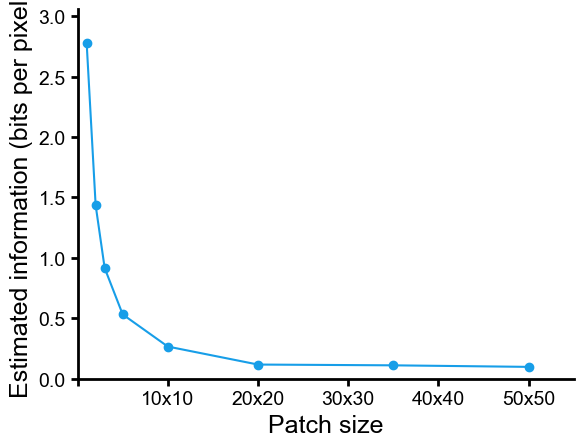

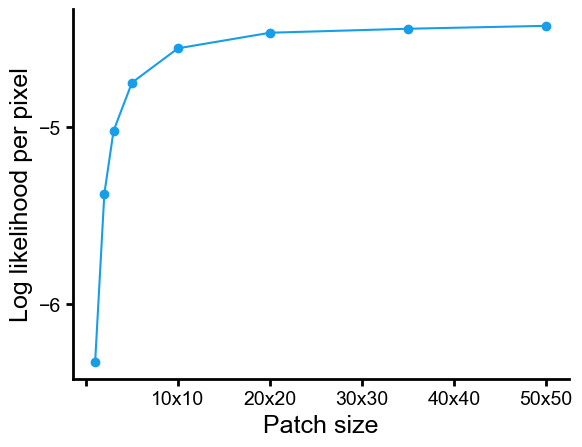

: 

In [ ]:
from matplotlib.ticker import MaxNLocator

# Mutual information vs patch size
fig, ax = plt.subplots()
ax.plot(patch_sizes, [mi_estimates_gp[ps] for ps in patch_sizes], 'o-', label='GP')
ax.plot(patch_sizes, [mi_estimates_pixel_cnn[ps] for ps in patch_sizes], 'o-', label='PixelCNN')
clear_spines(ax)
ax.set(xlabel='Patch size', ylabel='Estimated information (bits per pixel)', ylim=[0, 1.1 * 
                        max(max(mi_estimates_gp.values()), max(mi_estimates_pixel_cnn.values()))  ],
        xlim=[0, 1.1 * max(patch_sizes)], xticks=np.arange(0, 51, 10))
ax.set(xticklabels=[''] +[f'{ps}x{ps}' for ps in np.arange(10, 51, 10)])
ax.legend()

fig, ax = plt.subplots()
nll_per_pixel_gp = [test_set_NLL_gp[ps] for ps in patch_sizes]
nll_per_pixel_pixel_cnn = [test_set_NLL_pixel_cnn[ps] for ps in patch_sizes]

ax.plot(patch_sizes, nll_per_pixel_gp, 'o-', label='GP')
ax.plot(patch_sizes, nll_per_pixel_pixel_cnn, 'o-', label='PixelCNN')

clear_spines(ax)
ax.set(xlabel='Patch size', ylabel='Negative Log likelihood per pixel')
ax.set(xticklabels=[''] + [f'{ps}x{ps}' for ps in np.arange(10, 51, 10)], xticks=np.arange(0, 51, 10))
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
ax.legend()
